In [1]:
import sys, h5py, pdb,time, glob, os
from importlib import reload
import pylab as pl, numpy as np
from numpy import log10 as log
from astropy import units as un, constants as cons
import scipy, scipy.stats
from scipy import interpolate
from matplotlib import ticker, patches
sys.path.append('/mnt/home/jstern/gizmo_analysis/pysrc/')

In [2]:
import workdirs as wd
import FIRE_files as ff
from FIRE_files import cosmo, u
from projectPlotBasics import *
import first_pass as l
cmap = pl.get_cmap('viridis')
figdir = wd.basedir+'figures/'
import matplotlib.image as mpimg

Behroozi+18 not loaded
palettable colormaps are not installed
don't have phil's colormaps


In [3]:
CF_path = '/mnt/home/jstern/cooling_flow/pysrc'
sys.path.append(CF_path)
import cooling_flow as CF, HaloPotential as Halo
%matplotlib inline

In [4]:
#simname = 'vc200_Rs0_Mdot4847_Rcirc10_fgas02_res1e3_n10_NoLowCool'
#simname_lowres = 'vc200_Rs0_Mdot4847_Rcirc10_fgas02_res1e4_n10_NoLowCool_tracking'
simname = 'vc200_Rs0_Mdot1035_Rcirc15_fgas02_res1e3'
vc = 200. *un.km/un.s
Rcirc = 15.*un.kpc
snapshot_dt_Myr = 50
simdir = wd.simdir+'/%s/output/'%simname
#simdir_lowres = wd.simdir+'/%s/output/'%simname_lowres
Nsnapshots,dt,rmax,subsample = 45,50,40,10
ts = -np.arange(Nsnapshots)*dt
ts = ts-ts[-1]

In [5]:
sim = l.KY_sim(simname,simdir,200*un.kpc,origin=np.zeros(3),Rcirc = Rcirc,snapshot_dt_Myr=snapshot_dt_Myr,pr=False,
              analyticGravity= Halo.PowerLaw(m=0.,vc_Rvir=vc,Rvir=200*un.kpc))
sim.z = 0 #for cooling function
print(sim.galaxyname, sim.Nsnapshots())

vc200_Rs0_Mdot1035_Rcirc15_fgas02_res1e3 72


In [6]:
snapshot = sim.getSnapshot(71)
prof = sim.getProfiler(71)

In [7]:
xs,ys,zs = [snapshot.coords()[:,i] for i in range(3)]
zs += 0.25 #disk is offset for some reason
phis = np.arctan2(ys,xs)
Rs = (xs**2+ys**2)**0.5
rs = (Rs**2+zs**2)**0.5
thetas = np.arccos(zs/rs)

In [8]:
bins_Rs = np.arange(0.,40.1,0.1);  midbins_Rs = (bins_Rs[1:]+bins_Rs[:-1])/2
bins_zs = np.arange(-20.1,20.11,0.1); midbins_zs = (bins_zs[1:]+bins_zs[:-1])/2
Ts_cyl,_,_,bin_inds = scipy.stats.binned_statistic_2d(Rs,zs,log(snapshot.Ts()),statistic='median',bins=(bins_Rs,bins_zs))  

In [9]:
bins_Rs = 10.**np.arange(-1.,2.1,0.02); midbins_Rs = (bins_Rs[1:]+bins_Rs[:-1])/2
bins_zs = 10.**np.arange(-1.,2.1,0.02); midbins_zs = (bins_zs[1:]+bins_zs[:-1])/2
Ts_cyl,_,_,bin_inds    = scipy.stats.binned_statistic_2d(Rs,zs,log(snapshot.Ts()),  statistic='median',bins=(bins_Rs,bins_zs))  
nHs_cyl,_,_,bin_inds   = scipy.stats.binned_statistic_2d(Rs,zs,log(snapshot.nHs()), statistic='median',bins=(bins_Rs,bins_zs))  
vphis_cyl,_,_,bin_inds = scipy.stats.binned_statistic_2d(Rs,zs,snapshot.v_phi(),    statistic='median',bins=(bins_Rs,bins_zs))  

/mnt/home/jstern/gizmo_analysis/pysrc/FIRE_files.py:341: RuntimeWarning: divide by zero encountered in true_divide
  return j_z / (self.rs()*self.sin_theta(z_vec))


In [10]:
_nHs2   = np.concatenate([nHs_cyl[::-1,:],nHs_cyl],axis=0)
_vphis2 = np.concatenate([vphis_cyl[::-1,:],vphis_cyl],axis=0)
_Ts2    = np.concatenate([Ts_cyl[::-1,:],Ts_cyl],axis=0)
_Rs2    = np.concatenate([-midbins_Rs[::-1],midbins_Rs],axis=0)
x = np.arange(0, _Ts2.shape[1])
y = np.arange(0, _Ts2.shape[0])
#mask invalid values
for i,arr in enumerate((_Ts2,_vphis2,_nHs2)):
    array = np.ma.masked_invalid(arr)
    xx, yy = np.meshgrid(x, y)
    #get only the valid values
    x1 = xx[~array.mask]
    y1 = yy[~array.mask]
    newarr = array[~array.mask]
    arr_fixed = interpolate.griddata((x1, y1), newarr.ravel(),(xx, yy),method='cubic')
    arr_fixed = arr_fixed[len(midbins_Rs):]
    if i==0: Ts_cyl_fixed = arr_fixed
    if i==1: nHs_cyl_fixed = arr_fixed
    if i==2: vphis_cyl_fixed = arr_fixed

In [13]:
np.savez('/mnt/home/jstern/ceph/sim_analysis/solution.npz',
         logTs=Ts_cyl_fixed,log_nHs = nHs_cyl_fixed,vphis = vphis_cyl_fixed,Rs=bins_Rs,zs=bins_zs)

In [11]:
# bins_Rs_quiver = np.arange(0.,20.5,1);  midbins_Rs_quiver = (bins_Rs_quiver[1:]+bins_Rs_quiver[:-1])/2
# bins_zs_quiver = np.arange(-10,10.5,1); midbins_zs_quiver = (bins_zs_quiver[1:]+bins_zs_quiver[:-1])/2
# _vRs = snapshot.vs()[:,0]*np.cos(phis) + snapshot.vs()[:,1]*np.sin(phis)
# vRs,_,_,bin_inds = scipy.stats.binned_statistic_2d(Rs,zs,_vRs,              statistic='mean',bins=(bins_Rs_quiver,bins_zs_quiver))  
# vzs,_,_,bin_inds = scipy.stats.binned_statistic_2d(Rs,zs,snapshot.vs()[:,2],statistic='mean',bins=(bins_Rs_quiver,bins_zs_quiver))  

In [12]:
bins_xs = np.arange(-40.1,40.11,0.1); midbins_xs = (bins_xs[1:]+bins_xs[:-1])/2
bins_ys = np.arange(-40.1,40.11,0.1); midbins_ys = (bins_ys[1:]+bins_ys[:-1])/2
inds    = np.abs(zs)<10
Ts_faceon,_,_,bin_inds = scipy.stats.binned_statistic_2d(xs[inds],ys[inds],log(snapshot.Ts()[inds]),statistic='median',bins=(bins_xs,bins_ys))  

# fix for nan values

In [13]:
for i,_Ts in enumerate((Ts_cyl,Ts_faceon)):
    if i==0:
        _Ts2 = np.concatenate([_Ts[::-1,:],_Ts],axis=0)
        _Rs2 = np.concatenate([-midbins_Rs[::-1],midbins_Rs],axis=0)
    else:
        _Ts2,_Rs2 = _Ts,midbins_Rs
    x = np.arange(0, _Ts2.shape[1])
    y = np.arange(0, _Ts2.shape[0])
    #mask invalid values
    array = np.ma.masked_invalid(_Ts2)
    xx, yy = np.meshgrid(x, y)
    #get only the valid values
    x1 = xx[~array.mask]
    y1 = yy[~array.mask]
    newarr = array[~array.mask]
    Ts_fixed = interpolate.griddata((x1, y1), newarr.ravel(),(xx, yy),method='cubic')
    if i==0: Ts_cyl_fixed = Ts_fixed[len(midbins_Rs):]
    else: Ts_faceon_fixed = Ts_fixed
#pl.pcolormesh(midbins_Rs,midbins_zs,(Ts_cyl_fixed).T,
#                     zorder=-100,vmin=Tmin,vmax=Tmax,shading='nearest')


In [14]:
# bins_xs_quiver = np.arange(-30,31,2.5); midbins_xs_quiver = (bins_xs_quiver[1:]+bins_xs_quiver[:-1])/2
# bins_ys_quiver = np.arange(-30,31,2.5); midbins_ys_quiver = (bins_ys_quiver[1:]+bins_ys_quiver[:-1])/2
# vxs,_,_,bin_inds = scipy.stats.binned_statistic_2d(xs[inds],ys[inds],snapshot.vs()[:,0][inds],statistic='mean',bins=(bins_xs_quiver,bins_ys_quiver))  
# vys,_,_,bin_inds = scipy.stats.binned_statistic_2d(xs[inds],ys[inds],snapshot.vs()[:,1][inds],statistic='mean',bins=(bins_xs_quiver,bins_ys_quiver))  

In [15]:
npz_fn = wd.tracksdir+simname+'/particle_tracks_%d_%d_%d_all.npz'%(Nsnapshots,dt,rmax)
f = np.load(npz_fn)
coords_tracks,vs_tracks,Ts_tracks,nHs_tracks,tcools_tracks=f['coords'],f['vs'],f['Ts'],f['nHs'],f['tcools'][:,::5,...]

In [14]:
xs_tracks,ys_tracks,zs_tracks = [coords_tracks[:,:,i] for i in range(3)]
zs_tracks += 0.25 #disk is offset for some reason
rs_tracks    = (xs_tracks**2+ys_tracks**2+zs_tracks**2)**0.5
Rs_tracks    = (xs_tracks**2+ys_tracks**2)**0.5
thetas_tracks = np.arccos(zs_tracks/rs_tracks)
phis_tracks  = np.arctan2(ys_tracks,xs_tracks)

In [15]:
dphis_tracks = ((phis_tracks[:-1,:]-phis_tracks[1:,:])%(2*np.pi))[::-1].cumsum(axis=0)[::-1]
dphis_tracks = np.pad(dphis_tracks,((0,1),(0,0)),mode='constant')

In [16]:
l = 13
theta_midbins = np.arccos(np.linspace(-1.,1,l)); print('theta bins:', theta_midbins/np.pi)
phi_midbins = np.linspace(0.05,2,l+1)[:-1]*np.pi
dtheta = 0.025*np.pi
theta_inds = np.zeros((len(theta_midbins),thetas_tracks.shape[1]))
phi_inds   = np.zeros((len(theta_midbins),thetas_tracks.shape[1]))
theta_infty = np.median(thetas_tracks[-10:,:],axis=0)
phi_infty = phis_tracks[-1,:]+(2*np.pi)*(phis_tracks[-1,:]<0)
for itheta,theta_midbin in enumerate(theta_midbins):
    theta_inds[itheta,:] = (theta_infty<theta_midbin       +dtheta) & (theta_infty>theta_midbin       -dtheta)
    phi_inds[itheta,:]   = (phi_infty  <phi_midbins[itheta]+dtheta) & (phi_infty  >phi_midbins[itheta]-dtheta)
theta_inds = theta_inds.astype('bool'); phi_inds = phi_inds.astype('bool')
tracks = [None]*len(theta_midbins); tracks_by_phis = [None]*len(theta_midbins)
for i,ind in enumerate(theta_midbins):
    tracks[i]         = [np.nanmean(vals[:,theta_inds[i]],              axis=1) for vals in (Rs_tracks,zs_tracks)]
    tracks_by_phis[i] = [phi_midbins[i]*iii+np.nanmean(vals[:,theta_inds[6] & phi_inds[i]],axis=1) for iii,vals in enumerate((Rs_tracks,dphis_tracks))]

theta bins: [1.         0.8135705  0.73227953 0.66666667 0.60817345 0.55330038
 0.5        0.44669962 0.39182655 0.33333333 0.26772047 0.1864295
 0.        ]


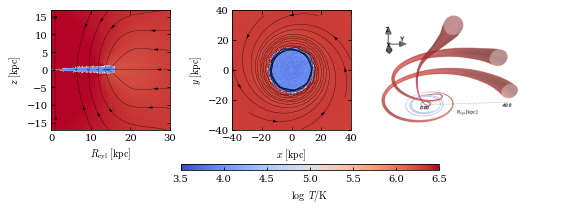

In [17]:
Tmin,Tmax = 3.5,6.5
fig = pl.figure(figsize=(fig_width_full*1.1,3.15))
gs = matplotlib.gridspec.GridSpec(1,3,wspace=0.45,right=0.99,left=0.03,width_ratios=(2,2,3.))
gs2 = matplotlib.gridspec.GridSpec(1,2,right=0.95,left=0.03)
ax3 = fig.add_subplot(gs2[1]); pl.axis('off')
img = mpimg.imread(figdir+'3Dtracks_mayavi.png')
imgplot = ax3.imshow(img)
ax1 = fig.add_subplot(gs[0])
mesh = pl.pcolormesh(midbins_Rs,midbins_zs,Ts_cyl_fixed.T,cmap='coolwarm',
                     zorder=-100,vmin=Tmin,vmax=Tmax,shading='nearest') 
# pl.quiver(midbins_Rs_quiver,midbins_zs_quiver,vRs.T,vzs.T)
for i,ind in enumerate(theta_midbins):
    pl.plot(tracks[i][0],tracks[i][1],c='k',lw=0.3)
    n = (10,16,20,21,15,15,15,15,15,21,20,16,10)[i]
    pl.arrow(tracks[i][0][-n], tracks[i][1][-n], 
              -tracks[i][0][-n]+tracks[i][0][-n-1],
              -tracks[i][1][-n]+tracks[i][1][-n-1], 
             shape='full', lw=0, length_includes_head=True, head_width=0.75,color='k')

pl.ylim(-17,17); pl.xlim(0,30)
pl.xlabel(r'$R_{\rm cyl}\ [{\rm kpc}]$')
pl.ylabel(r'$z\ [{\rm kpc}]$')
ax1.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax1.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax2 = fig.add_subplot(gs[1])
ax2.xaxis.set_major_locator(ticker.MultipleLocator(20))
ax2.yaxis.set_major_locator(ticker.MultipleLocator(20))
mesh = pl.pcolormesh(midbins_xs,midbins_ys,Ts_faceon_fixed.T,cmap='coolwarm',
                     zorder=-100,vmin=Tmin,vmax=Tmax,shading='nearest') 
# pl.quiver(midbins_xs_quiver,midbins_ys_quiver,vxs.T,vys.T)
for i in range(0,len(tracks_by_phis),2):
    _xs = tracks_by_phis[i][0]*np.cos(tracks_by_phis[i][1])
    _ys = tracks_by_phis[i][0]*np.sin(tracks_by_phis[i][1])
    pl.plot(_xs,_ys,c='k',lw=0.3) 
    n = 5#(10,16,20,21,15,15,15,15,15,21,20,16,10)[i]
    pl.arrow(_xs[-n], _ys[-n], 
              -_xs[-n]+_xs[-n-1],
              -_ys[-n]+_ys[-n-1], 
             shape='full', lw=0, length_includes_head=True, head_width=2,color='k')

pl.xlabel(r'$x\ [{\rm kpc}]$')
pl.ylabel(r'$y\ [{\rm kpc}]$')
pl.ylim(-40,40); pl.xlim(-40,40)
cb = pl.colorbar(mesh,ax=(ax1,ax2,ax3),orientation='horizontal',label=r'$\log\ T/{\rm K}$',
                 shrink=0.5,fraction=0.1,aspect=40,pad=0.2)
pl.clim(Tmin,Tmax)
pl.savefig(figdir+'snapshot_map.png',bbox_inches='tight',dpi=600)

In [ ]:
bins_rs = np.arange(0,50.01,0.1); midbins_rs = (bins_rs[1:]+bins_rs[:-1])/2
inds    = np.abs(thetas-np.pi/2)<0.1
Ts_faceon,_,_,bin_inds = scipy.stats.binned_statistic(rs[inds],log(snapshot.Ts()[inds]),statistic='median',bins=(bins_xs,bins_ys))  

# check offset in z is fixed

In [18]:
bins_Rs2 = np.arange(0.,40.1,1);  midbins_Rs2 = (bins_Rs2[1:]+bins_Rs2[:-1])/2
bins_zs2 = np.arange(-2.1,2.1,0.01); midbins_zs2 = (bins_zs2[1:]+bins_zs2[:-1])/2
Ts_cyl2,_,_,bin_inds2 = scipy.stats.binned_statistic_2d(Rs,zs,log(snapshot.Ts()),statistic='median',bins=(bins_Rs2,bins_zs2))  

(-2.0, 2.0)

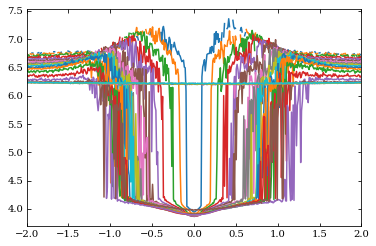

In [21]:
for i in range(0,20):
    pl.plot(midbins_zs2,Ts_cyl2[i,:])
    #print(midbins_Rs2[i],midbins_zs2[Ts_cyl2[i,:].argmin()])
pl.xlim(-2,2)

# hot gas profile plot

In [85]:
(0.62 * cons.m_p * (200*un.km/un.s)**2 / (5/3*cons.k_B*0.9)).to('K')

<Quantity 2002972.21125775 K>

In [24]:
print(snapshot.mus()[inds].min(),snapshot.mus()[inds].max(),ff.mu)
print(snapshot.ne2nHs()[inds].min(),snapshot.ne2nHs()[inds].max(),ff.ne2nH)

0.5951522 0.5951525 0.62
1.171864 1.1718651 1.2


### check Mdot

Text(0, 0.5, '$\\dot{M}\\ [{\\rm M}_\\odot\\,{\\rm yr}^{-1}]$')

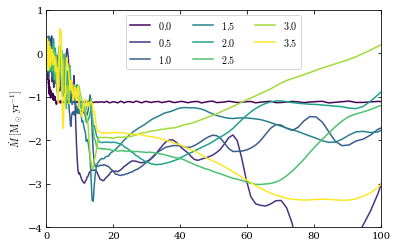

In [70]:
cmap = pl.get_cmap('viridis')
for i in range(8):
    prof = sim.getProfiler(i*10)
    pl.plot(prof.rs_midbins(), prof.MdotProfile(),label=r'$%.1f$'%(0.5*i),c=cmap(i/7))
    prof.tofile()
pl.legend(ncol=3)
pl.xlim(0,100)
pl.ylim(-4,1)
pl.ylabel(r'$\dot{M}\ [{\rm M}_\odot\,{\rm yr}^{-1}]$')

### check v_c

saved massProfile0
saved massProfile2
saved massProfile4


Text(0, 0.5, '$v_{\\rm c}$')

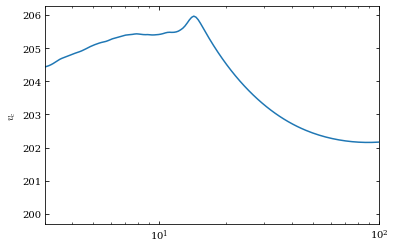

In [16]:
prof = sim.getProfiler(70)
pl.semilogx(prof.rs_midbins(), prof.vc())
prof.tofile()
pl.xlim(3,100)
pl.ylabel(r'$v_{\rm c}$')

# unknown plot

In [10]:
inds = (snapshot.Ts()<4e5) & (snapshot.Ts()>2e5) & (Rs>8) & (Rs<10)

NameError: name 'Rs' is not defined

In [ ]:
nHs = snapshot.nHs()
tcools = snapshot.t_cool()

In [30]:
js = np.array([coords[:,1] * vs[:,2] - coords[:,2] * vs[:,1],
               coords[:,2] * vs[:,0] - coords[:,0] * vs[:,2],
               coords[:,0] * vs[:,1] - coords[:,1] * vs[:,0]])
js=js.T
jzs = js[:,2]

In [31]:
vphis = jzs/Rs
Omegas = jzs/Rs**2 * un.km/un.s/un.kpc
vzs = vs[:,2]
vRs = (vs[:,0]*xs/rs + vs[:,1]*ys/rs)
vrs = (vs[:,0]*xs/rs + vs[:,1]*ys/rs + vs[:,2]*zs/rs)
# cos𝜃cos𝜙𝐱+cos𝜃sin𝜙𝐲−sin𝜃𝐳)𝜃
vthetas = vs[:,0]*np.cos(thetas)*np.cos(phis) + vs[:,1]*np.cos(thetas)*np.sin(phis) - vs[:,2]*np.sin(thetas)

$v_\theta$ mean=16.973, std=30.950
$v_r$ mean=-10.770, std=26.731
$v_\phi$ mean=213.642, std=24.410
$v_R$ mean=-10.196, std=26.616
$v_{|z|}$ mean=-17.283, std=31.048


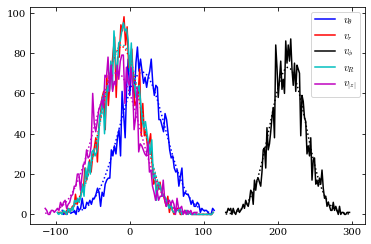

In [129]:
above_plane = (-1)**(zs<0.3)
vspherical = [(vthetas*above_plane)[inds],vrs[inds],vphis[inds],vRs[inds],(above_plane*vzs)[inds]]
for iv,v in enumerate(vspherical):
    c = 'brkcm'[iv]
    label = (r'$v_\theta$',r'$v_r$',r'$v_\phi$',r'$v_R$',r'$v_{|z|}$')[iv]
    a,b=pl.histogram(v,bins=100)
    mean,std = np.mean(v),np.std(v); print(label, 'mean=%.3f, std=%.3f'%(mean,std))
    bb = (b[1:]+b[:-1])/2; db = bb[1]-bb[0]
    pl.plot(bb,a,c=c,label=label)
    pl.plot(bb,scipy.stats.norm.pdf(bb,loc=mean,scale=std)*a.sum()*db,c=c,ls=':')
    pl.legend()

In [46]:
ls =((1e4*un.Msun/(4*np.pi/3*cons.m_p*nHs*un.cm**-3/0.7))**(1/3)).to('kpc')

In [54]:
(ls.to('cm')*nHs*un.cm**-3*ls**2/(2*un.kpc*2*np.pi*9*un.kpc))[inds].sum() * 5e-4*0.2/3

<Quantity 1.62538128e+14 1 / cm2>

In [61]:
np.median(ls[inds])

<Quantity 0.10943618 kpc>

In [60]:
np.median(nHs[inds])*1e-4/3

1.7197967817385993e-06

In [65]:
np.median(tcools[inds])

1.9614762444724372

In [69]:
(10*un.kpc / (200*un.km/un.s)).to('Myr')

<Quantity 48.88961108 Myr>

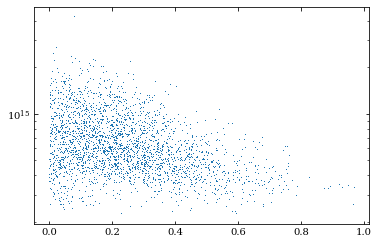

In [124]:
pl.semilogy(np.abs(zs[inds]-0.3),(ls*nHs*un.kpc.to('cm')*1e-4/3)[inds],',')

# verify cooling calculation is similar to that in FIRE

In [100]:
import os, glob
from scipy import interpolate
tables_dir = os.getenv("HOME")+'/github_repositories/gizmo_analysis/CoolingTables/'

def LambdaFile(z):
    fns = np.array(glob.glob(tables_dir+'z_?.???.hdf5'))
    zs = np.array([float(fn[-10:-5]) for fn in fns])
    fn = fns[zs.argsort()][u.searchsortedclosest(sorted(zs), z)]
    print(fn)
    f=h5py.File(fn,'r')
    return f

In [102]:
Zsun = [0.0129,0.2806,2.07e-3,8.36e-4,5.49e-3,1.41e-3,5.91e-4,6.83e-4,4.09e-4,6.44e-5,1.1e-3]

In [103]:
LAMBDA1 = ff.LambdaFunc(0)
print(LAMBDA1(2e6,0.1,0.1))
f = LambdaFile(0)
a = snapshot.dic['PartType0','Metallicity'][inds][0]
FIRE_inds = ['Z','Helium','Carbon','Nitrogen','Oxygen','Neon','Magnesium','Silicon','Sulphur','Calcium','Iron']
iHe = u.searchsortedclosest(f['Metal_free']['Helium_mass_fraction_bins'][:],a[1])
H_He_Cooling  = f['Metal_free']['Net_Cooling'][iHe,...]
Tbins         = f['Metal_free']['Temperature_bins'][...]
nHbins        = f['Metal_free']['Hydrogen_density_bins'][...]
Metal_Cooling = np.sum([f[FIRE_inds[i]]['Net_Cooling'][...]*a[i]/Zsun[i] for i in range(2,11)],axis=0)
f_H_He = interpolate.RegularGridInterpolator((log(Tbins), log(nHbins)),
                                                    H_He_Cooling,
                                                    bounds_error=False, fill_value=None)
f_Z    = interpolate.RegularGridInterpolator((log(Tbins), log(nHbins)),
                                                    Metal_Cooling,
                                                    bounds_error=False, fill_value=None)
f2 = lambda T,nH,f_H_He=f_H_He,f_Z=f_Z: (
        f_H_He((log(T), log(nH))) + f_Z((log(T), log(nH))))
f2(2e6,0.001)


1.4038108602647772e-23
/home/ysz5546/github_repositories/gizmo_analysis/CoolingTables/z_0.000.hdf5


1.3182569998698887e-23

In [173]:
bins_Rs = np.arange(-0.5,12.5,0.05); midbins_Rs = (bins_Rs[1:]+bins_Rs[:-1])/2
bins_zs = np.arange(-2.1,2.11,0.05); midbins_zs = (bins_zs[1:]+bins_zs[:-1])/2
hist_Ts,a,b,bin_inds = scipy.stats.binned_statistic_2d(Rs,zs,log(snapshot.Ts()),statistic='mean',bins=(bins_Rs,bins_zs))  
hist_vzs,a,b,bin_inds = scipy.stats.binned_statistic_2d(Rs,zs,np.abs(snapshot.vs()[:,2]),statistic='mean',bins=(bins_Rs,bins_zs))  

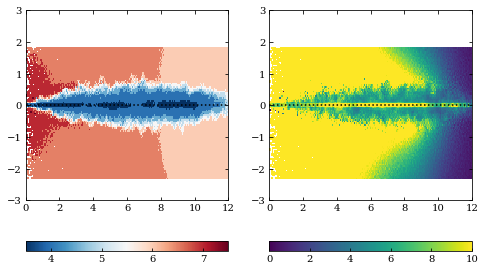

In [180]:
pl.figure(figsize=(8,5))
for iPanel in range(2):
    ax = pl.subplot(1,2,iPanel+1)
    if iPanel==0:
        mesh = pl.pcolormesh(midbins_Rs,midbins_zs-0.25,0.5*((hist_Ts.T+0.25)//0.5),cmap='RdBu_r',zorder=-100) 
    if iPanel==1:
        mesh = pl.pcolormesh(midbins_Rs,midbins_zs-0.25,(hist_vzs / (200*30*np.abs(midbins_zs-0.25))**0.5).T,
                             cmap='viridis',zorder=-100,vmax=10,vmin=0) 
    pl.ylim(-3,3); pl.xlim(0,12)
    cb = pl.colorbar(orientation='horizontal')
#     for i,ind in enumerate(theta_midbins):
#         pl.plot(tracks[i][0],tracks[i][1],c='k')
    pl.axhline(0,c='k',ls=':')

In [60]:
(10**3.5/2e6)**0.5 * 10

0.39763536438352537

In [151]:
bins_Rs = np.arange(-0.5,12.5,0.05); midbins_Rs = (bins_Rs[1:]+bins_Rs[:-1])/2
bins_zs = np.arange(0,2.11,0.05); midbins_zs = (bins_zs[1:]+bins_zs[:-1])/2
hist_masses,a,b,bin_inds = scipy.stats.binned_statistic_2d(
    np.concatenate([(snapshot.coords(j)[:,:2]**2).sum(axis=1)**0.5 for j in range(6) if j!=1]),
    np.concatenate([np.abs(snapshot.coords(j)[:,2]-0.25) for j in range(6) if j!=1]),
    np.concatenate([snapshot.masses(j) for j in range(6) if j!=1]),
    statistic='sum',bins=(bins_Rs,bins_zs))  

In [152]:
hist_masses.shape,  midbins_zs.shape, midbins_Rs.shape

((259, 42), (42,), (259,))

In [153]:
midbins_Rs_grid,midbins_zs_grid = np.meshgrid(midbins_Rs,midbins_zs)
g_isothermal = (200*un.km/un.s)**2 / (midbins_Rs_grid*un.kpc) * midbins_zs_grid / midbins_Rs_grid

In [154]:
gs = (2*np.pi*cons.G * hist_masses.sum(cumsum(axis=1).T*un.Msun / (0.05*un.kpc)**2).to('km**2*s**-2/kpc')


In [172]:
# gz ~ vc^2
((2*np.pi*cons.G*1e10*un.Msun / (np.pi*(10*un.kpc)**2) * 1*un.kpc)**0.5).to('km/s')

<Quantity 29.3288843 km / s>

In [166]:
np.searchsorted(midbins_Rs,10)

210

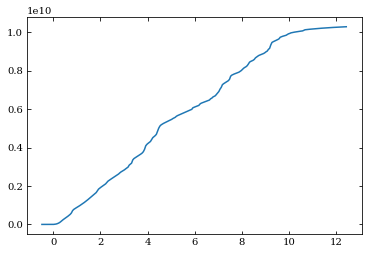

In [169]:
pl.plot(midbins_Rs,hist_masses.cumsum(axis=1).cumsum(axis=0)[:,-1])

In [155]:
#point source: 4pi r^2 g = 4 pi GM 
#plane parallel 2Ag = 4 pi G sigma A -> g = 2 pi G sigma

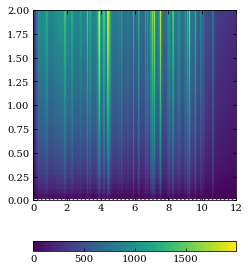

In [157]:
pl.figure(figsize=(8,5))
for iPanel in range(1,2):
    ax = pl.subplot(1,2,iPanel+1)
    if iPanel==0:
        mesh = pl.pcolormesh(midbins_Rs,midbins_zs-0.25,0.5*((hist_Ts.T+0.25)//0.5),cmap='RdBu_r',zorder=-100) 
    if iPanel==1:
        mesh = pl.pcolormesh(midbins_Rs,midbins_zs,(gs*midbins_zs_grid)**0.5,
                             cmap='viridis',zorder=-100) 
    pl.ylim(0,2); pl.xlim(0,12)
    cb = pl.colorbar(orientation='horizontal')
#     for i,ind in enumerate(theta_midbins):
#         pl.plot(tracks[i][0],tracks[i][1],c='k')
    pl.axhline(0,c='k',ls=':')

In [103]:
snapshot.dic[('PartType0','Masses')][:100]

array([0.01771542, 0.01771542, 0.01771542, 0.01771542, 0.01771542,
       0.01771542, 0.01771542, 0.01771542, 0.01771542, 0.01771542,
       0.01771542, 0.01771542, 0.01771542, 0.01771542, 0.01771542,
       0.01771542, 0.01771542, 0.01771542, 0.01771542, 0.01771542,
       0.01771542, 0.01771542, 0.01771542, 0.01771542, 0.01771542,
       0.01771542, 0.01771542, 0.01771542, 0.01771542, 0.01771542,
       0.01771542, 0.01771542, 0.01771542, 0.01771542, 0.01771542,
       0.01771542, 0.01771542, 0.01771542, 0.01771542, 0.01771542,
       0.01771542, 0.01771542, 0.01771542, 0.01771542, 0.00590503,
       0.01771542, 0.01771542, 0.01771542, 0.01771542, 0.01771542,
       0.01771542, 0.01771542, 0.00590503, 0.00590503, 0.00590503,
       0.00590503, 0.00590503, 0.00590503, 0.00590503, 0.00590503,
       0.01771542, 0.00590503, 0.01771542, 0.01771542, 0.01771542,
       0.00590503, 0.00590503, 0.01771542, 0.01771542, 0.01771542,
       0.00590503, 0.00590503, 0.00590503, 0.00590503, 0.00590

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([-100,  -99,  -98,  -97,  -96,  -95,  -94,  -93,  -92,  -91,  -90,
         -89,  -88,  -87,  -86, 

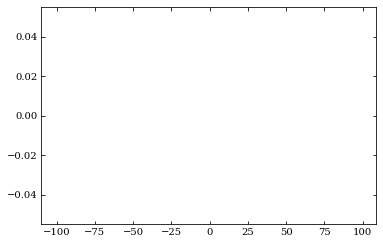

In [92]:
pl.hist(log(snapshot.masses()),bins=np.arange(-100,100))

In [77]:
a=snapshot.dic[('PartType0','Potential')]

KeyError: "Unable to open object (object 'Potential' doesn't exist)"